In [116]:
import matplotlib
# %matplotlib inline
# print("BACKEND: ", matplotlib.get_backend())
# if matplotlib.get_backend() != "macosx":
#   print("Changing backend to macosx")
#   matplotlib.use('macosx')


In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import numpy as np

In [118]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [119]:
from agox.models.descriptors import SOAP
local_descriptor = local_descriptor = SOAP.from_species(["Al"], r_cut=5.0)


In [120]:
import glob
from chgnet.model import CHGNetCalculator
calc = CHGNetCalculator()
# # for each POSCAR_[0-9] in iteration*/, read in to Atoms() object and attach calculator
# poscar_files = glob.glob("iteration*/POSCAR_[0-9]")
# atoms_list = []
# for poscar_file in poscar_files:
#   atoms = read(poscar_file)
#   atoms.calc =calc
#   atoms_list.append(atoms)


CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [ ]:
# for each POSCAR_[0-9] in iteration*/, read in to Atoms() object and attach calculator
poscar_files = glob.glob("DKnown_phases/*.vasp")
known_phases = []
opacity_list = []
for poscar_file in poscar_files:
  phase = read(poscar_file)
  opacity = None
  if "mp-134.vasp" in poscar_file:
    print("FCC")
    cell = phase.get_cell()
    cell = [ vec * 4.02 / np.linalg.norm(vec) for vec in cell]
    phase.set_cell(cell, scale_atoms=True)
    opacity = 1.0
  elif "mp-2647008.vasp" in poscar_file:
    print("HCP")
    cell = phase.get_cell()
    cell = [ vec * 3.56 / np.linalg.norm(vec) for vec in cell]
    phase.set_cell(cell, scale_atoms=True)
    opacity = 0.6
  elif "mp-998860.vasp" in poscar_file:
    print("BCC")
    cell = phase.get_cell()
    cell = [ vec * 3.10 / np.linalg.norm(vec) for vec in cell]
    phase.set_cell(cell, scale_atoms=True)
    opacity = 0.4
  elif "mp-1183144.vasp" in poscar_file:
    print("Weird")
    cell = phase.get_cell()
    # cell[0] = [ vec * 4.94 / np.linalg.norm(vec) for vec in cell]
    # cell[1] = [ vec * 4.94 / np.linalg.norm(vec) for vec in cell]
    cell[2] = cell[2] * 9.88 / np.linalg.norm(cell[2])
    phase.set_cell(cell, scale_atoms=True)
    opacity = 0.8
  else:
    print("Skipping ", poscar_file)
    continue
  opacity_list.append(opacity)
  phase.calc = calc
  known_phases.append(phase)

BCC
Weird


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [81]:
seed = 0
# min_energy = -3.6635127# -3.7717605425

In [82]:
unrlxd_structures = read("DTMP_right_lattice_constant/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures:
  structure.calc = calc

In [83]:
rlxd_structures = read("DTMP_right_lattice_constant/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures:
  structure.calc = calc
min_energy = np.min([structure.get_potential_energy()/len(structure) for structure in rlxd_structures])

In [84]:
# Calculate energies per atom for each unique structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unrlxd_structures]
unrlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Unrelaxed min energy: ", np.min(energies_per_atom))

Unrelaxed min energy:  -3.5716178


In [85]:
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in rlxd_structures]
rlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Relaxed min energy: ", np.min(energies_per_atom))

Relaxed min energy:  -3.6635127


In [86]:
from sklearn.decomposition import PCA

In [87]:
pca = PCA(n_components=2)

In [88]:
unrlxd_super_atoms = []
for structure in unrlxd_structures:
  unrlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [89]:
rlxd_super_atoms = []
for structure in rlxd_structures:
  rlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [90]:
known_super_atoms = []
for structure in known_phases:
  known_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [91]:
rlxd_string = "rlxd" # which dataset to fit the PCA model to

In [92]:
# save pca model
import pickle
if True:
  pca.fit(np.squeeze([arr for arr in rlxd_super_atoms]))
  with open("pca_model_all_rlxd_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

# load pca model
with open("pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [93]:
unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in unrlxd_super_atoms]))
rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in rlxd_super_atoms]))
known_X_reduced = pca.transform(np.squeeze([arr for arr in known_super_atoms]))

In [94]:
min_energy_index = np.argmin(rlxd_delta_en_per_atom)
print(min_energy_index)

1356


0 0.4
1 0.8
2 1.0
3 0.6
0 0.4
1 0.8
2 1.0
3 0.6


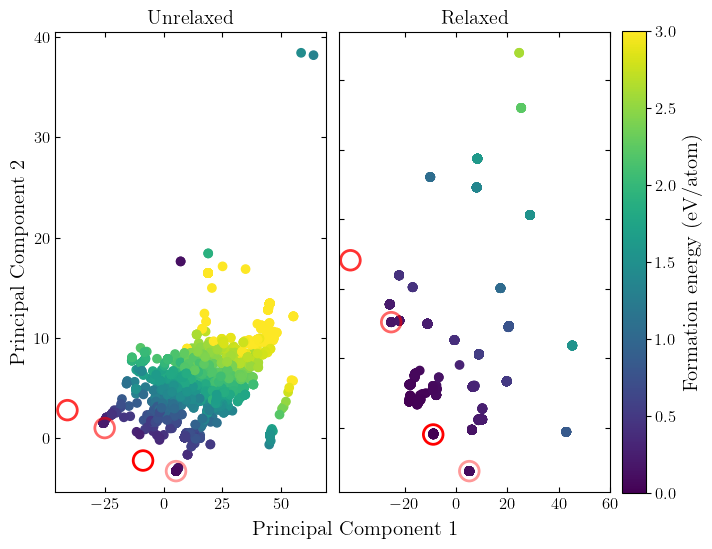

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

max_en = min(3.0, max(np.max(unrlxd_delta_en_per_atom), np.max(rlxd_delta_en_per_atom)))

axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=unrlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=rlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
for ax in axes:
  # ax.scatter(rlxd_X_reduced[min_energy_index, 0], rlxd_X_reduced[min_energy_index, 1], s=200, edgecolor='red', facecolor='none', linewidth=2)
  for i, X in enumerate(known_X_reduced):
    # if opacity_list[i] == 1.0 or opacity_list[i] == 0.8:
    #   continue
    print(i, opacity_list[i])
    ax.scatter(X[0], X[1], s=200, edgecolor=[1.0, 0.0, 0.0, opacity_list[i]], facecolor='none', linewidth=2)
  

fig.text(0.5, 0.04, 'Principal Component 1', ha='center', fontsize=15)
axes[0].set_ylabel('Principal Component 2', fontsize=15)
axes[0].set_title('Unrelaxed')
axes[1].set_title('Relaxed')
if rlxd_string == "rlxd":
  xlims = [-30, 65]
  ylims = [-5, 40]
else:
  xlims = [-42, 55]
  ylims = [-12, 30]

for ax in axes:
  ax.tick_params(axis='both', direction='in')
  # ax.set_xlim(xlims)
  # ax.set_ylim(ylims)

# unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]

axes[1].set_xticks(xticks)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

# Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

# Add colorbar next to the axes
cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
cbar.set_label('Formation energy (eV/atom)', fontsize=15)

plt.savefig('Al_RAFFLE_pca_'+rlxd_string+'_fit_seed'+str(seed)+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')